<h1 id="intro">Introduction - Model Training Walkthrough</h1>
- Author: Myles Dunlap


This notebook is used to train a model using a single configuration file. Additional pre-training tasks are provided as well as further analysis techniques for model selection.

## Table of Contents
- [User Inputs](#user-inputs)
- [Import Libraries and Modules](#import-libs)
- [Load Config. and Setup](#config)
- [Workflow](#workflow)
- [Pre-process Target](#preprocess-target)
- [Tokenizer and Collator](#tokenizer)
- [Datasets and DataLoaders](#datasets)
- [Learning Rate Finder and Scheduler](#lr)
- [Train the Model](#training)
- [Visualize Learning Curves](#learning-curves)
- [Model Selection and Experimenting](#model-selection)
- [Experiment Tracking Tools](#exp-track)


<h1 id="user-inputs">User Inputs</h1>

##### [Return To Top](#intro)

In [1]:
# Append the path for the custom modules
path_custom_modules = '../'

# Path to the YAML config. file
path_cfg = {'base_dir': '../cfgs',
            'filename': 'train-0-notebook.yaml'}

<h1 id="import-libs">Import Libraries and Modules</h1>

##### [Return To Top](#intro)

In [2]:
# Libraries
import os
import sys
from pathlib import Path
import gc
from transformers import AutoTokenizer
import torch

# Append Path to Custom Modules if Needed
sys.path.append('../')

# Custom Modules
from src.utils import (seed_everything,
                       load_cfg,
                       RunIDs)
from src.dataloading.load_data import LoadData
from src.dataloading.stratify import StratifyData
from src.dataloading.preprocess import PreprocessData
from src.dataloading.load_datasets import (CustomTextCollator,
                                           get_ds_dl,
                                           )
from src.training.single_fold import train_fold
from src.training.single_fold import train_fold

# Setup HF env. variables
os.environ['TRANSFORMERS_OFFLINE'] = '1'
os.environ['TOKENIZERS_PARALLELISM'] = 'True'
os.environ['TRANSFORMERS_NO_ADVISORY_WARNINGS'] = 'true'

<h1 id="config">Load Config. and Setup</h1>

This section if focused on:
- loading the config. file,
- setting up directories for saving results, 
- seeding.

##### [Return To Top](#intro)

In [3]:
# Seed Everything
SEED = 42
seed_everything(seed=SEED)

# Get Device type for processing
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the configuration file
CFG = load_cfg(base_dir=Path(path_cfg['base_dir']),
               filename=path_cfg['filename'])

# Create directories for saving results and use unique Group ID
run_ids = RunIDs(test_folds=CFG.cv.val_folds,
                    num_folds=CFG.cv.num_folds,
                    save_dir=CFG.paths.save_results.base_dir,
                    save_results=CFG.paths.save_results.apply_metric)
run_ids.generate_run_ids()

# Print the group id and ids for each fold
print(f'Group ID: {run_ids.group_id}')
for fold_num in CFG.cv.val_folds:
    fold_id = getattr(run_ids.folds_id,
                      f'fold{fold_num}').run_id
    entire_id = f'{run_ids.group_id}-{fold_id}' 
    print((f'ID for Testing Fold #{fold_num}: '
           f'{fold_id}\n\tFull/Entire ID: {entire_id}'))

Group ID: da44f4c8
ID for Testing Fold #1: 40a7990e
	Full/Entire ID: da44f4c8-40a7990e


<h1 id="workflow">Workflow</h1>

The primary workflow begins in this section. Notice that prior to this section the key piece of information obtained is the configuration file. If multiple configurations needed to be processed this would be the entry point for those configuration files. For example, in the [training Python script](../scripts/train_model.py) for automating over various configuration files the workflow section is introduced with the `workflow` function.

Note: Only one fold of data will be analyzed in the notebook since this is for demonstration purposes. In the [training Python script](../scripts/train_model.py) all folds are trained.

##### [Return To Top](#intro)

In [4]:
# Load Data from Disk
load_data_file = LoadData(base_dir=CFG.paths.data.base_dir)
data = load_data_file.load(filename=CFG.paths.data.data)

# Stratify the Data
data = (StratifyData(technique=CFG.stratify.technique,
                     n_folds=CFG.cv.num_folds,
                     target=CFG.data_info.target)
        .stratify(df=data))

# Input and target field names
cols = CFG.data_info.source_fields + \
       [CFG.data_info.target, 'fold']

# Train a model for one validation fold
fold_num = CFG.cv.val_folds[0]

# Print information
display(data[cols].head(5))
print(f'Distribution of a Product for Each Fold')
print(f'Notice how the quantities are evenly distributed across folds')
display(data.groupby('Product').fold.value_counts()
        .sort_index().head(5))

,Consumer complaint narrative,ZIP code,Sub-issue,Product,fold
0,I became in contact with th fraud Dept of TOTA...,836XX,Card was charged for something you did not pur...,Credit card or prepaid card,1
1,I attended college from XX/XX/XXXX through XX/...,787XX,Don't agree with the fees charged,Student loan,1
2,I recently paid off my automotive account off ...,94142,Account status,Credit reporting,1
3,WITH MIDLAND CREDIT THAT IS A THIRD PARTY COMP...,301XX,Debt was result of identity theft,Debt collection,1
4,I contacted Toyota financial services to dispu...,900XX,Account status incorrect,Vehicle loan or lease,1


Distribution of a Product for Each Fold
Notice how the quantities are evenly distributed across folds


Product                      fold
Credit card or prepaid card  1       500
                             2       500
Credit reporting             1       500
                             2       500
Debt collection              1       500
Name: count, dtype: int64

In [5]:
# Split Data into Training and Validation
df_train = data.copy()[data.fold != fold_num].reset_index(drop=True)
df_val = data.copy()[data.fold == fold_num].reset_index(drop=True)
print('Number of Instances:')
print(f'\tTrain: {len(df_train):,}')
print(f'\tVal.: {len(df_val):,}')

Number of Instances:
	Train: 2,500
	Val.: 2,500


<h1 id="preprocess-target">Pre-process Target</h1>

Convert the text target into a label.

In [6]:
# Preprocessing Encoders
encoders = {}
for technique in CFG.preprocessing.apply_techniques:
    fields = getattr(CFG.preprocessing, technique).fields
    for col in fields:
        enc = PreprocessData(y=df_train[col].values,
                            technique=technique)
        encoders[col] = {'encoder': enc.encoder,
                        'technique': technique}
print(encoders)

{'Product': {'encoder': LabelEncoder(), 'technique': 'LabelEncoder'}}


<h1 id="tokenizer">Tokenizer and Collator</h1>

A collator is an object that forms a batch of data by using a list of dataset elements as inputs. 

The module [load_datasets.py](../src/dataloading/load_datasets.py) has a custom collator class used here and it has several benefits such as:
- The data does **NOT** have to be tokenized prior to being passed to the PyTorch DataLoader class. Lots of online examples show the data already tokenized before going into a dataloader. Using the approach in this repo. means the text data is tokenized once a batch of data is processed in the DataLoader class and it allows for RAM usage to stay lower. For example, if your dataset exceeds the available RAM size then tokenizing all the data prior to the DataLoader (e.g., in the Dataset class) could become problematic.
- Using a custom collator enables dynamic padding over the batches. Later the maximum token length for a few batches will be printed to illustrate dynamic padding. This ultimately leads to faster processing of data as explained in this [HuggingFace YouTube video](https://www.youtube.com/watch?v=7q5NyFT8REg).

##### [Return To Top](#intro)

In [7]:
# Path to the model and tokenizer model card saved on disk
model_path = Path(CFG.model_tokenizer.base_dir) / CFG.model_tokenizer.name

# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_path, do_lower=True)

# Collator
collator = CustomTextCollator(tokenizer=tokenizer,
                              tokenizer_cfg=CFG.tokenizer)

<h1 id="datasets">Datasets and DataLoaders</h1>
## Combine Mixed data type fields

In this [blob post by Chris McCormick](https://mccormickml.com/2021/06/29/combining-categorical-numerical-features-with-bert/) an interesting approach was taken to combine mixed data types which was to convert all categorical and numerical into the text feed into the LLM. This technique is used in this repository as shown in the `TrainDataset` class in the module [load_dataset.py](../src/dataloading/load_datasets.py). 

Another approach is only pass the unstructured text into the LLM, take its last layer output and combine with the other mixed data types into a dense layer. This type of approach seems more common and an example can be found on [Google Colab here](https://colab.research.google.com/drive/1F7COnwHqcLDPg_SS-oFgW3c2GPDWnS5Y#scrollTo=BAQFbN-wBpoz).

As a reminder this data has `categorical` and `unstructued` input fields that will be combined. More information on these variables can be found in the [eda.ipynb](./eda.ipynb) notebook and summarized below for convenience:

- Number of Independent variables = 3
    - `Consumer complaint narrative`: string of unstructured text and all instances are unique 
    - `ZIP code`: a categorical variable with high cardinality (i.e., > 20K unique values)
    - `Sub-issues`: a categorical variable with 63 unique values
- Dependent Variable = `Product`
    - `Product`: categorical with 5 unique values

##### [Return To Top](#intro)

In [8]:
# Train Dataset and Dataloader
(_,
train_dataloader) = get_ds_dl(df=df_train,
                              cfg=CFG,
                              tokenizer=tokenizer,
                              encoder=encoders[CFG.data_info.target]['encoder'],
                              collator=collator)
# Validation Dataset and Dataloader
(_,
val_dataloader) = get_ds_dl(df=df_val,
                            cfg=CFG,
                            tokenizer=tokenizer,
                            encoder=encoders[CFG.data_info.target]['encoder'],
                            collator=collator)

print(f'# of Training Samples: {len(df_train):,}')
print(f'# of Validation Samples: {len(df_val):,}')
print(f'Batch Size: {CFG.batch_size}')
print(f'{len(df_train):,} \ {CFG.batch_size:,} = {len(train_dataloader):,}')
print(f'Train DataLoader # of Iters: {len(train_dataloader):,}')
print(f'Val. DataLoader # of Iters: {len(val_dataloader):,}')

# Dynamic Padding of Maximum Token Lengths
print(f'\nDynamic Padding\n\tThe shape is [batch size, maximum token length]')
for i, inputs in enumerate(train_dataloader):
    if i > 10:
        break
    else:
        print((f'Batch {i + 1} of {len(train_dataloader):,}: '
               f'{inputs["input_ids"].shape}'))

# Display output from dataloader
print(f'Batch of data keys:\n{inputs.keys()}')

# of Training Samples: 2,500
# of Validation Samples: 2,500
Batch Size: 16
2,500 \ 16 = 157
Train DataLoader # of Iters: 157
Val. DataLoader # of Iters: 157

Dynamic Padding
	The shape is [batch size, maximum token length]
Batch 1 of 157: torch.Size([16, 482])
Batch 2 of 157: torch.Size([16, 512])
Batch 3 of 157: torch.Size([16, 512])
Batch 4 of 157: torch.Size([16, 512])
Batch 5 of 157: torch.Size([16, 512])
Batch 6 of 157: torch.Size([16, 512])
Batch 7 of 157: torch.Size([16, 512])
Batch 8 of 157: torch.Size([16, 512])
Batch 9 of 157: torch.Size([16, 512])
Batch 10 of 157: torch.Size([16, 512])
Batch 11 of 157: torch.Size([16, 454])
Batch of data keys:
dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'labels'])


The dynamic padding is shown above and notice that the maximum token length for some batches is < 512. Using dynamic padding allows for faster training and inference.

<h1 id="lr">Learning Rate Finder and Scheduler</h1>

This section will look at useful tools to help with determining a learning rate before training the mode. Learning rate is one of the most important parameters when tuning deep learning models.

##### [Return To Top](#intro)

### Learning Rate Finder

A useful tool to help find a suitable range for the learning rate is a `learning rate finder`. One package that works well is [torch-lr-finder](https://pypi.org/project/torch-lr-finder/). 

Before kicking-off the initial training of a model it is useful evaluate the lr-finder plot to help in selecting a learning rate. Please realize this does not need to be called in production but can be used by the developer at the start of a project.

In [9]:
from torch_lr_finder import LRFinder, TrainDataLoaderIter
from torch import nn
from torch.optim import AdamW
from IPython.display import clear_output
from src.models.llm_multiclass import CustomModel
from src.training.optimizers import get_optimizer

# Load custom model
model = CustomModel(llm_model_path=model_path,
                    cfg=CFG.model,
                    num_classes=df_train[CFG.data_info.target].nunique())

# Set model on device
model.to(DEVICE)
clear_output()

# Class to iterate over dataloader
class TrainIter(TrainDataLoaderIter):
    def inputs_labels_from_batch(self, batch):
        return ({'input_ids': batch['input_ids'],
                 'attention_mask': batch['attention_mask']},
                batch['labels'])
train_data_iter = TrainIter(train_dataloader)

# Learning Rate Finder
lr_finder = LRFinder(model,
                     AdamW(filter(lambda p: p.requires_grad, model.parameters())),
                     nn.CrossEntropyLoss(),
                     device="cuda")
lr_finder.range_test(train_data_iter,
                     start_lr=1.0e-8,
                     end_lr=5.0e-4,
                     num_iter=100,
                     step_mode="linear")
lr_finder.plot(log_lr=False)
lr_finder.reset()

A few notes in the above learning rate finder plot:
- The upper bound is ~3.0E-4 so learning rates above this will cause erratic behavior.
- The lower bound is <1.0E-4 where learning may not occur as quickly.
- This is a rather tight range for the learning rate and could be investigated further.

In experiments not shown in the notebook it was found that setting a learning rate >=1.0E-3 caused the model to not learn and converge to predicting a single class.

### Learning Rate Scheduler

Learning rate schedulers can be used to help an algorithm converge to a more optimal solution. Please refer to this references for more information and a visual representation of various learning rate schedules.
 - [Medium Article](https://towardsdatascience.com/a-visual-guide-to-learning-rate-schedulers-in-pytorch-24bbb262c863)
 - [Kaggle Notebook](https://www.kaggle.com/code/isbhargav/guide-to-pytorch-learning-rate-scheduling)

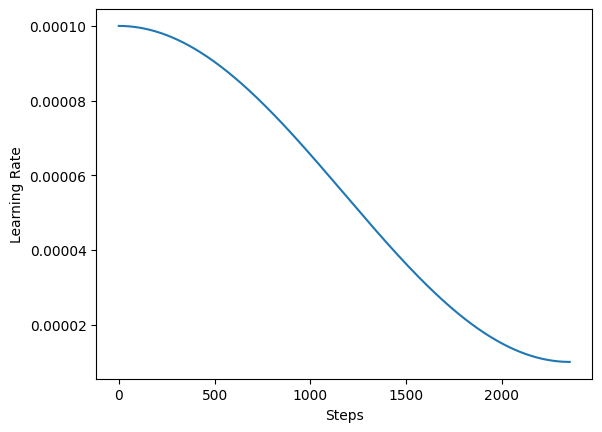

In [10]:
from torch.optim.lr_scheduler import CosineAnnealingLR, OneCycleLR
import matplotlib.pyplot as plt

# Optimizer
optimizer = get_optimizer(cfg=CFG.optimizer,
                          model=model)

# Learning rate scheduler
# scheduler = OneCycleLR(optimizer=optimizer,
#                        total_steps=total_steps,
#                        max_lr=CFG.optimizer.lr.max)

scheduler = CosineAnnealingLR(optimizer,
                              T_max=CFG.epochs * len(train_dataloader),
                              eta_min=CFG.lr_scheduler.CosineAnnealingLR.eta_min)
lr_value = []
steps = []
step_count = 0
for epoch in range(CFG.epochs):
    for batch_count in range(len(train_dataloader)):
        optimizer.step()
        lr_value.append(optimizer.param_groups[0]['lr'])
        steps.append(step_count)
        scheduler.step()
        step_count +=1

# Plot Learning Rate Schedule
plt.plot(steps, lr_value)
plt.xlabel('Steps')
plt.ylabel('Learning Rate')
plt.show()

In [11]:
import gc
# Set model to none to free GPU memory
model = None

# Clean up memory and variables
del (model, optimizer, scheduler, lr_value,
     steps, step_count,
    #  lr_finder, train_data_iter,
     )

# Release cached memory
torch.cuda.empty_cache()
_ = gc.collect()


<h1 id="training">Train the Model</h1>

The process of training the model for a single fold of data is conducted by the module [single_fold.py](../src/training/single_fold.py).

The performance metrics `perf_metrics` are both the training and validation performance scores for f1, precision, recall, and loss at each epoch. 

### References

- Loss Functions
    - [Machine Learning Mastery](https://machinelearningmastery.com/how-to-choose-loss-functions-when-training-deep-learning-neural-networks/)
    - [Neptune AI Article](https://neptune.ai/blog/pytorch-loss-functions)
    - [PyTorch Loss Functions](https://pytorch.org/docs/stable/nn.html#loss-functions)
    - Since this is a multi-class classification we can use nn.CrossEntropyLoss as the loss function. More elaborate modules can be built for selecting and creating custom loss functions.


-   Performance Metrics
    - [TorchMetrics](https://torchmetrics.readthedocs.io/en/latest/) will be used for implementing performance metrics.
        - [F1-Score](https://torchmetrics.readthedocs.io/en/stable/classification/f1_score.html), [Precision](https://torchmetrics.readthedocs.io/en/stable/classification/precision.html), [Recall](https://torchmetrics.readthedocs.io/en/stable/classification/recall.html)


##### [Return To Top](#intro)

In [12]:
# Path to save model results
model_save_path = getattr(run_ids.folds_id, f'fold{fold_num}').path

# Training for a single fold
perf_metrics = train_fold(train_dl=train_dataloader,
                          val_dl=val_dataloader,
                          cfg=CFG,
                          device=DEVICE,
                          n_classes=df_train[CFG.data_info.target].nunique(),
                          model_save_path=model_save_path)

Some weights of the model checkpoint at ../hf_download/bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).



Start Epoch 1


Epoch 1: 100%|██████████| 157/157 [00:52<00:00,  2.97batch/s, f1=0.787, loss=0.5119, precision=0.809, recall=0.812]


Epoch 1 Training Time: 0.88 minutes
	Training: loss=0.5029; f1=0.791; precision=0.812; recall=0.816


Val. at Epoch: 1: 100%|██████████| 157/157 [00:18<00:00,  8.48batch/s]


	Val.: loss=0.1922; f1=0.924; precision=0.932; recall=0.933

Start Epoch 2


Epoch 2: 100%|██████████| 157/157 [00:52<00:00,  3.01batch/s, f1=0.944, loss=0.1628, precision=0.952, recall=0.952]


Epoch 2 Training Time: 0.87 minutes
	Training: loss=0.1611; f1=0.945; precision=0.953; recall=0.953


Val. at Epoch: 2: 100%|██████████| 157/157 [00:18<00:00,  8.42batch/s]


	Val.: loss=0.1907; f1=0.929; precision=0.939; recall=0.937

Start Epoch 3


Epoch 3: 100%|██████████| 157/157 [00:53<00:00,  2.94batch/s, f1=0.970, loss=0.0894, precision=0.974, recall=0.975]


Epoch 3 Training Time: 0.89 minutes
	Training: loss=0.0894; f1=0.970; precision=0.974; recall=0.975


Val. at Epoch: 3: 100%|██████████| 157/157 [00:18<00:00,  8.42batch/s]


	Val.: loss=0.1800; f1=0.928; precision=0.938; recall=0.937

Start Epoch 4


Epoch 4: 100%|██████████| 157/157 [00:53<00:00,  2.94batch/s, f1=0.974, loss=0.0846, precision=0.979, recall=0.978]


Epoch 4 Training Time: 0.89 minutes
	Training: loss=0.0825; f1=0.975; precision=0.980; recall=0.978


Val. at Epoch: 4: 100%|██████████| 157/157 [00:18<00:00,  8.41batch/s]


	Val.: loss=0.1185; f1=0.963; precision=0.969; recall=0.968

Start Epoch 5


Epoch 5: 100%|██████████| 157/157 [00:53<00:00,  2.95batch/s, f1=0.976, loss=0.0627, precision=0.978, recall=0.980]


Epoch 5 Training Time: 0.89 minutes
	Training: loss=0.0620; f1=0.976; precision=0.979; recall=0.980


Val. at Epoch: 5: 100%|██████████| 157/157 [00:18<00:00,  8.37batch/s]


	Val.: loss=0.1199; f1=0.955; precision=0.960; recall=0.961

Start Epoch 6


Epoch 6: 100%|██████████| 157/157 [00:53<00:00,  2.95batch/s, f1=0.995, loss=0.0181, precision=0.996, recall=0.996]


Epoch 6 Training Time: 0.89 minutes
	Training: loss=0.0180; f1=0.995; precision=0.996; recall=0.996


Val. at Epoch: 6: 100%|██████████| 157/157 [00:18<00:00,  8.35batch/s]


	Val.: loss=0.1177; f1=0.961; precision=0.967; recall=0.966

Start Epoch 7


Epoch 7: 100%|██████████| 157/157 [00:53<00:00,  2.93batch/s, f1=0.992, loss=0.0234, precision=0.994, recall=0.993]


Epoch 7 Training Time: 0.89 minutes
	Training: loss=0.0251; f1=0.992; precision=0.994; recall=0.992


Val. at Epoch: 7: 100%|██████████| 157/157 [00:18<00:00,  8.37batch/s]


	Val.: loss=0.1434; f1=0.960; precision=0.964; recall=0.966

Start Epoch 8


Epoch 8: 100%|██████████| 157/157 [00:53<00:00,  2.94batch/s, f1=0.998, loss=0.0094, precision=0.999, recall=0.998]


Epoch 8 Training Time: 0.89 minutes
	Training: loss=0.0091; f1=0.998; precision=0.999; recall=0.998


Val. at Epoch: 8: 100%|██████████| 157/157 [00:18<00:00,  8.30batch/s]


	Val.: loss=0.1173; f1=0.970; precision=0.972; recall=0.975

Start Epoch 9


Epoch 9: 100%|██████████| 157/157 [00:53<00:00,  2.95batch/s, f1=0.999, loss=0.0058, precision=0.999, recall=0.999]


Epoch 9 Training Time: 0.89 minutes
	Training: loss=0.0057; f1=0.999; precision=0.999; recall=0.999


Val. at Epoch: 9: 100%|██████████| 157/157 [00:18<00:00,  8.45batch/s]


	Val.: loss=0.1194; f1=0.972; precision=0.976; recall=0.976

Start Epoch 10


Epoch 10: 100%|██████████| 157/157 [00:53<00:00,  2.92batch/s, f1=0.999, loss=0.0019, precision=1.000, recall=0.999]


Epoch 10 Training Time: 0.90 minutes
	Training: loss=0.0020; f1=0.999; precision=1.000; recall=0.999


Val. at Epoch: 10: 100%|██████████| 157/157 [00:18<00:00,  8.35batch/s]


	Val.: loss=0.1210; f1=0.968; precision=0.972; recall=0.972

Start Epoch 11


Epoch 11: 100%|██████████| 157/157 [00:53<00:00,  2.93batch/s, f1=1.000, loss=0.0019, precision=1.000, recall=1.000]


Epoch 11 Training Time: 0.89 minutes
	Training: loss=0.0019; f1=1.000; precision=1.000; recall=1.000


Val. at Epoch: 11: 100%|██████████| 157/157 [00:18<00:00,  8.33batch/s]


	Val.: loss=0.1218; f1=0.970; precision=0.974; recall=0.974

Start Epoch 12


Epoch 12: 100%|██████████| 157/157 [00:53<00:00,  2.92batch/s, f1=1.000, loss=0.0006, precision=1.000, recall=1.000]


Epoch 12 Training Time: 0.90 minutes
	Training: loss=0.0007; f1=1.000; precision=1.000; recall=1.000


Val. at Epoch: 12: 100%|██████████| 157/157 [00:18<00:00,  8.35batch/s]


	Val.: loss=0.1246; f1=0.965; precision=0.970; recall=0.969

Start Epoch 13


Epoch 13: 100%|██████████| 157/157 [00:53<00:00,  2.92batch/s, f1=1.000, loss=0.0006, precision=1.000, recall=1.000]


Epoch 13 Training Time: 0.90 minutes
	Training: loss=0.0006; f1=1.000; precision=1.000; recall=1.000


Val. at Epoch: 13: 100%|██████████| 157/157 [00:18<00:00,  8.32batch/s]


	Val.: loss=0.1281; f1=0.966; precision=0.970; recall=0.970

Start Epoch 14


Epoch 14: 100%|██████████| 157/157 [00:53<00:00,  2.94batch/s, f1=1.000, loss=0.0005, precision=1.000, recall=1.000]


Epoch 14 Training Time: 0.89 minutes
	Training: loss=0.0005; f1=1.000; precision=1.000; recall=1.000


Val. at Epoch: 14: 100%|██████████| 157/157 [00:18<00:00,  8.36batch/s]


	Val.: loss=0.1238; f1=0.971; precision=0.974; recall=0.975

Start Epoch 15


Epoch 15: 100%|██████████| 157/157 [00:53<00:00,  2.93batch/s, f1=1.000, loss=0.0005, precision=1.000, recall=1.000]


Epoch 15 Training Time: 0.89 minutes
	Training: loss=0.0005; f1=1.000; precision=1.000; recall=1.000


Val. at Epoch: 15: 100%|██████████| 157/157 [00:18<00:00,  8.31batch/s]

	Val.: loss=0.1250; f1=0.969; precision=0.974; recall=0.972
Total Training Time: 18.0 minutes


<h1 id="learning-curves">Visualize Learning Curves</h1>

The learning curves will be plotted using the returned `perf_metrics` dictionary. The learning curves provide a rich amount of information about model performance and is an excellent diagnostic tool. 

Please refer to the below articles explaining how to use an learning curves:
- [Machine Learning Mastery: How to use Learning Curves to Diagnose Machine Learning Model Performance](https://machinelearningmastery.com/learning-curves-for-diagnosing-machine-learning-model-performance/)
- [Baeldung: What Is a Learning Curve in Machine Learning?](https://www.baeldung.com/cs/learning-curve-ml)

##### [Return To Top](#intro)

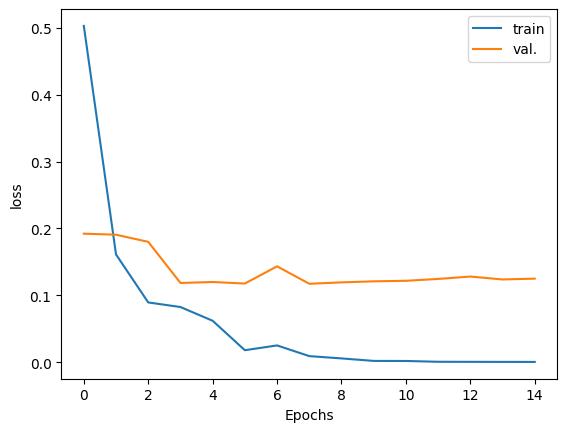

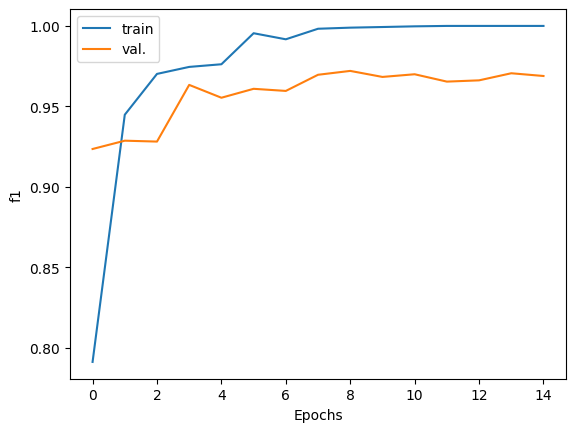

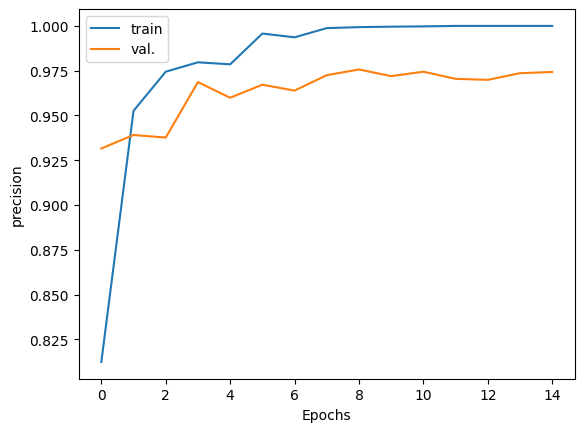

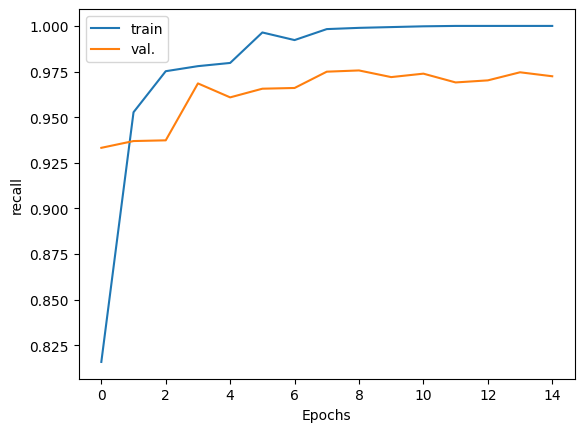

In [13]:
epochs = perf_metrics['epoch']
for metric_name in ['loss', 'f1', 'precision', 'recall']:
    y_train = perf_metrics[f'train_{metric_name}']
    y_val=perf_metrics[f'val_{metric_name}']
    # Create the plot
    fig, ax = plt.subplots(nrows=1, ncols=1)
    ax.plot(epochs, y_train, 'tab:blue',
            epochs, y_val, 'tab:orange')
    ax.legend(['train', 'val.'])
    ax.set_xlabel('Epochs')
    ax.set_ylabel(f'{metric_name}')
plt.show()

#### Practical Application of Learning Curves
Below is an illustration of training and validation loss curve and how they can be used to find the right bias/variance tradeoff 
<p align='center'>
    <img src='../doc/imgs/fitgraph.jpg'>
</p>
<p style="text-align: center;"> 
Image taken from <a href="https://www.baeldung.com/cs/learning-curve-ml">Baeldung</a>
</p>
    
For the example shown in this notebook, around what epoch do you think will provide a `good fitting` model? Looks like the model is starting to over fit around epoch 4.

<h1 id="model-selection">Model Selection and Experimenting</h1>

This notebook demonstrated fine-tuning of the BERT model on CFPB data for a `single` fold of data.

### Automated Tuning and Cross-Validation
To improve on this analysis a cross-validation can be performed more easily using the [../scripts/train_model.py](../scripts/train_model.py) script.

This script is best used by:
1) create a directory of different configuration YAML files. Set the various inputs in the configuration files to your liking and modify the code as needed to accommodate tests you want to run. This allows for a lot of flexibility in iterating over various input parameters, testing functions/modules, processes, etc.
2) Execute over the various configuration files using a bash script.

This process will now allow you to get away from the computer while it can run your highly configurable pipeline.

An example is show below:
```
Setup config YAML files with parameters of your choosing

├── ./cfgs/tune
│   ├── run0.yaml
│   ├── run1.yaml
│   ├── ...
│   ├── runN.yaml
```
To execute each yaml file in the `train_model.py` the below bash shell can be used:
```bash
#!/bin/bash

# Shell script to execute customized model training.
# YAML configurations files are used to control the training pipeline such as datasets, models, hyperparameters, etc.

cfgfiles=`ls ./cfgs/tune/*.yaml`
for cfgfile in $cfgfiles
do
   echo "$(basename "$cfgfile")"
   FILENAME="$(basename "$cfgfile")"
   python ./src/train_model.py --dir ./cfgs/tune/ --name $FILENAME
done
```

### C.V. and Holdout Test Set

To further investigate model performance and ensure a well fitting model a holdout test set can be used in conjunction with c.v. scores.

For example, say a 5 fold c.v. was performed and F1 score is the primary performance metric. You can take the average c.v. F1 score and plot it against the F1 score for the holdout set. This analysis provides an extra layer of certainty in select the best performing model/parameters/pipeline. An example of this analysis is shown in the below cell.

##### [Return To Top](#intro)

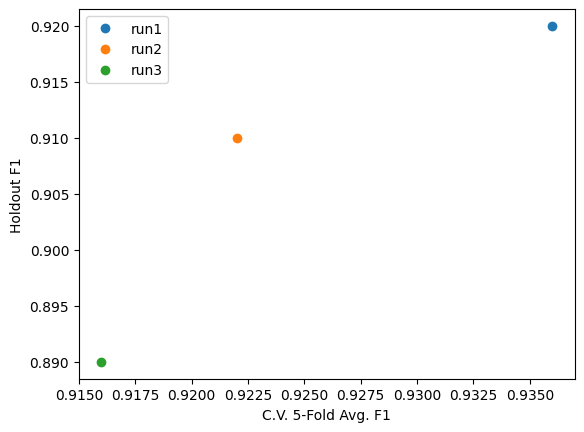

In [32]:
# 5-Fold C.V. F1 Scores for Three Config. YAML Runs
run1 = {'cv': [0.92, 0.96, 0.89, 0.94, 0.97],
        'holdout': 0.92}
run2 = {'cv': [0.90, 0.95, 0.87, 0.95, 0.94],
        'holdout': 0.91}
run3 = {'cv': [0.90, 0.92, 0.90, 0.91, 0.95],
        'holdout': 0.89}

# Plot c.v. vs. holdout
# Create the plot
fig, ax = plt.subplots(nrows=1, ncols=1)
for run in [run1, run2, run3]:
        # C.V. Average of all folds
        cv_avg = sum(run['cv']) / len(run['cv'])
        ax.plot(cv_avg, run['holdout'], 'o')
ax.legend(['run1', 'run2', 'run3'])
ax.set_xlabel('C.V. 5-Fold Avg. F1')
ax.set_ylabel(f'Holdout F1')
plt.show()

The above plots shows that `run1` is the best configuration to select because it has a high avg C.V. and holdout test performance. Using this type of analysis and plot lets you easily select the best performing models.


<h1 id="exp-track">Experiment Tracking Tools</h1>

Due to the highly iterative nature of deep learning model development the organization of experiments and their results can become very demanding. Several software exist for machine learning experiment tracking, hyperparameter tuning, results visualization, etc. A a few popular software are provided below and as well as a review article:

- [Tensoboards](https://www.tensorflow.org/tensorboard)
- [Weights and Biases](https://wandb.ai/site)
- [Neptune AI](https://neptune.ai/homepage)
- [A Comprehensive Comparison of ML Experiment Tracking Tools](https://towardsdatascience.com/a-comprehensive-comparison-of-ml-experiment-tracking-tools-9f0192543feb)

##### [Return To Top](#intro)